# Gradient descent

Is a cursial method for machine learning. But in general it's a way of optimising - finding values where the function depends on those values taking the minimum/maximum value. Here I'll try to implement a basic variation of gradient descent using only `numpy`. I'll explain each step to make everything clear.

In [41]:
import numpy as np
import plotly.graph_objects as go

## Task

Suppose we have classic linear regression task - we have array of point $(x_i, y_i)$ just like generated and visualised in the cell below:

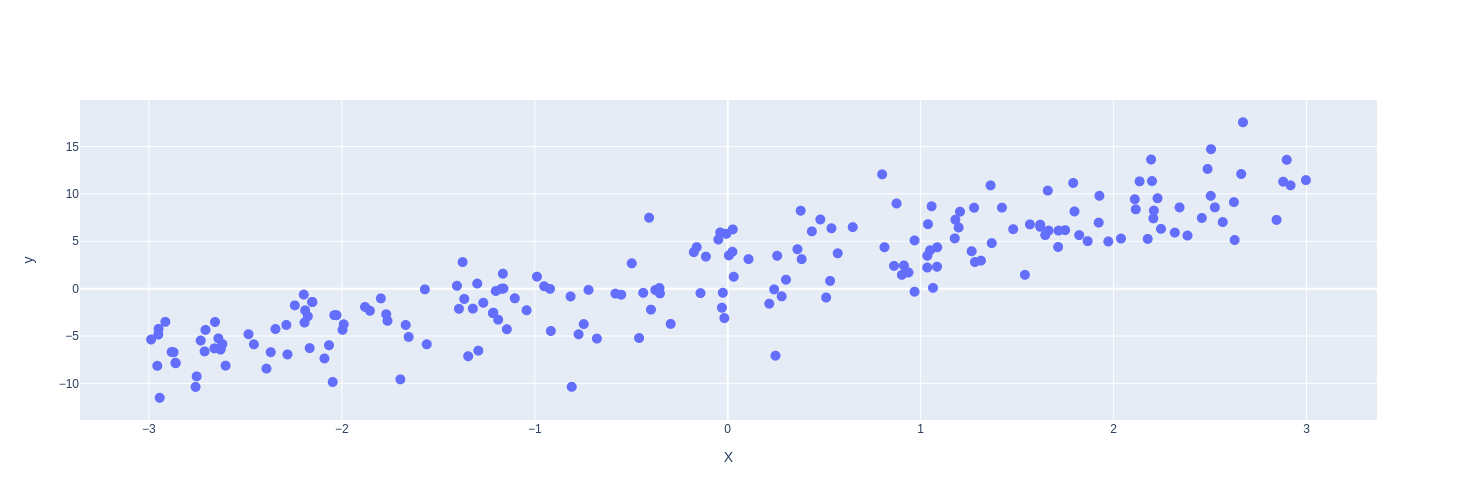

In [77]:
sample_size = 200

real_alpha = 3; real_beta = 2;

X = np.random.uniform(-3 , 3, sample_size)
y = X*alpha + beta + np.random.normal(0, 3, sample_size)


go.Figure(
    go.Scatter(x = X, y=y, mode = 'markers', marker_size = 10),
    layout={
        "xaxis_title" : "X",
        "yaxis_title" : "y",
        "width" : 1000,
        "height" : 500,
        "dragmode" : False
    }
)

We need to find such a function $y=x\alpha + \beta$ that produces the closest line to the array of points. More precisely to find $\alpha$ and $\beta$ that corresponds closes line.

We will use MSE as a loss function:

$$MSE(\alpha, \beta)=\sum_{i=1}^n \left[(x_i\alpha + \beta) - y_i\right]^2$$

The following code displays $MSE$ values for different values of $\alpha$ and $\beta$.

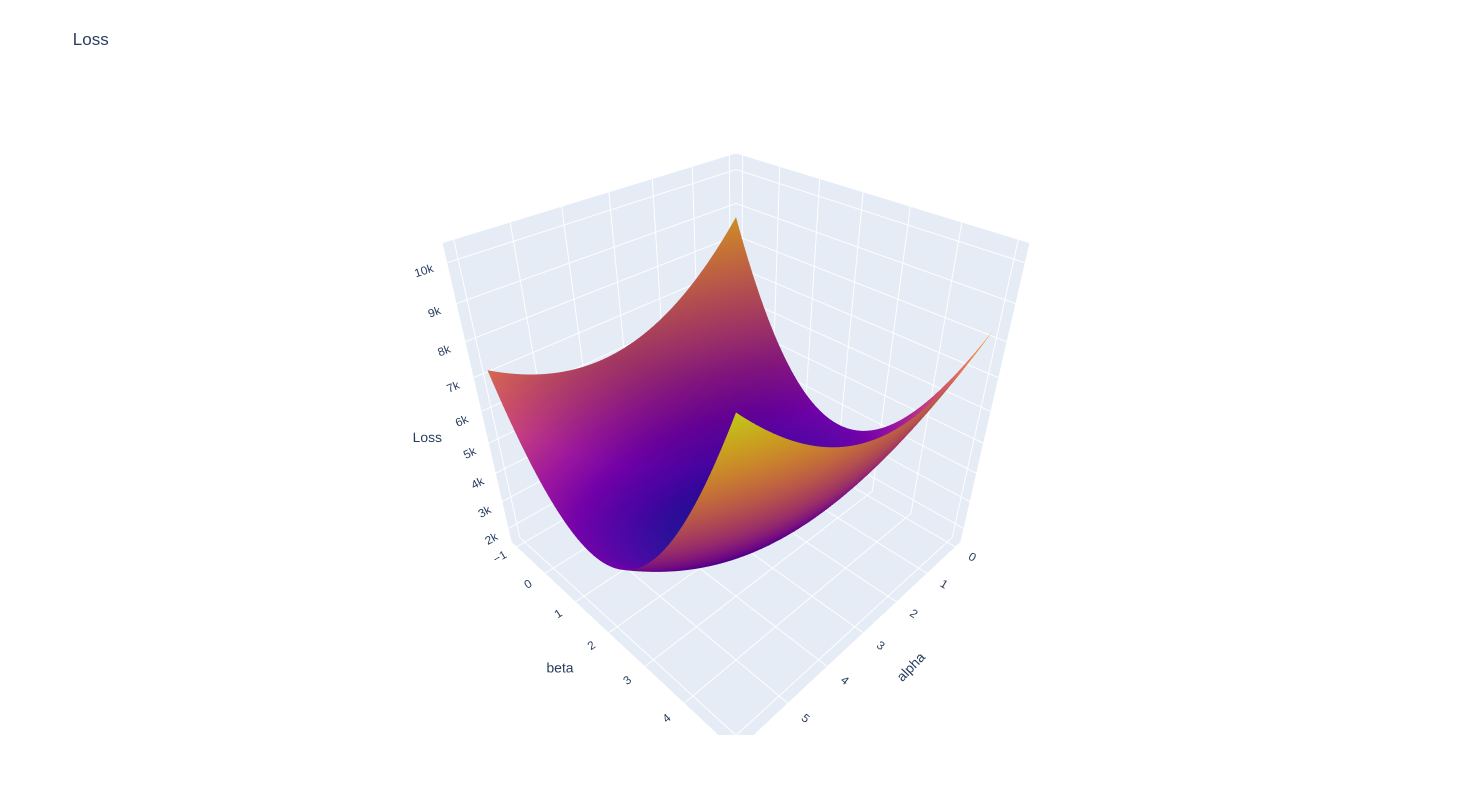

In [73]:
alphas = np.linspace(real_alpha-3, real_alpha+3, 50)
betas = np.linspace(real_beta-3, real_beta+3, 50)

grid = np.array([
    [((alpha*X + beta - y)**2).sum() for beta in betas] 
    for alpha in alphas
])

fig = go.Figure(data=[
    go.Surface(
        z=grid, x=alphas, y=betas,
        hovertemplate="alpha:%{x}<br>beta:%{y}<br>Loss:%{z}<extra></extra>",
        showscale=False
    )
])
fig.update_layout(
    title='Loss', autosize=False,
    width=600, height=800,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='alpha',
        yaxis_title='beta',
        zaxis_title='Loss'
    ),
    dragmode = "drawcircle"
)
fig.show()

Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

### Hint: пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [5]:
### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])

### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
scalar_value = (scalar_value - Y).values

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [6]:
### Возьмем столбик со значениями 1 признака
d_i1 = X.values[:, 0]

### Умножим каждый объект на соответствующее значение признака
scalar_value = scalar_value * d_i1

In [7]:
### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(scalar_value)

-27.62384887912409

### Эта логика поможем Вам при реализации класса!

learn(self)

метод возвращает итоговую среднеквадратическую ошибку.
метод итеративно вычисляет среднеквадратическую ошибку и вектор-градиент. номер итерации и MSE записываются в словарь *iteration_loss_dict*. критерий останова срабатывает тогда, когда абсолютное значение разницы двух последних MSE меньше *self.threshold*.

In [8]:
from IPython.display import clear_output

class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold = 1e-6, copy: bool = True):
        """
        self.samples - матрица признаков
        self.targets - вектор таргетов
        self.beta - вектор из изначальными весами модели == коэффициентами бета (состоит из единиц)
        self.learning_rate - параметр *learning_rate* для корректировки нормы градиента
        self.threshold - величина, меньше которой изменение в loss-функции означает остановку градиентного спуска
        iteration_loss_dict - словарь, который будет хранить номер итерации и соответствующую MSE
        copy: копирование матрицы признаков или создание изменения in-place
        """
        ### Your code is here
        self.samples = (samples.copy() if copy else samples) 
        self.targets = (targets.copy() if copy else targets)
        self.learning_rate = learning_rate
        self.treshold = threshold
        self.betas = np.ones(X.shape[1])

        
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        Метод создает колонку с константным признаком (interсept) в матрице признаков.
        Hint: так как количество признаков увеличилось на одну, не забудьте дополнить вектор с изначальными весами модели!
        """
        ### Your code is here
        self.samples["const"] = 1
        self.betas = np.concatenate([
            self.betas, [1]
        ])
        
    def calculate_mse_loss(self) -> float:
        """
        Метод для расчета среднеквадратической ошибки
        
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        ### Your code is here
        return ((self.targets.to_numpy() - np.dot(self.samples, self.betas))**2).sum()/len(self.samples)
    

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        Метод возвращает вектор-градиент, содержащий производные по каждому признаку.
        Сначала матрица признаков скалярно перемножается на вектор self.beta, и из каждой колонки
        полученной матрицы вычитается вектор таргетов. Затем полученная матрица скалярно умножается на матрицу признаков.
        Наконец, итоговая матрица умножается на 2 и усредняется по каждому признаку.
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        ### Your code is here
        scalar_value = np.dot(self.samples, self.betas.reshape(-1, 1)).ravel()
        scalar_value = (scalar_value - self.targets).values
        return np.fromiter(
            map(lambda i: (self.samples.iloc[:,i]*scalar_value).mean()*2, range(self.samples.shape[1])),
            dtype=float
        )
    
    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        ### Your code is here
        self.betas = self.betas - self.learning_rate*self.calculate_gradient()
        
    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        Запись mse и номера итерации в iteration_loss_dict
        
        Описание алгоритма работы для изменения бет:
            Фиксируем текущие beta -> start_betas
            Делаем шаг градиентного спуска
            Записываем новые beta -> new_betas
            Пока |L(new_beta) - L(start_beta)| > threshold:
                Повторяем первые 3 шага
                
        Описание алгоритма работы для изменения функции потерь:
            Фиксируем текущие mse -> previous_mse
            Делаем шаг градиентного спуска
            Записываем новые mse -> next_mse
            Пока |(previous_mse) - (next_mse)| > threshold:
                Повторяем первые 3 шага
        """
        ### Your code is here

        self.iteration_loss_dict = {}
        iteration_number = 0
        while True:
            #start_betas = self.betas
            previous_mse = self.calculate_mse_loss()
            self.iteration()
            next_mse = self.calculate_mse_loss()

            self.iteration_loss_dict[iteration_number] = next_mse
            iteration_number += 1
            
            if previous_mse - next_mse <= self.treshold:
                break
            print(next_mse)
            clear_output(wait=True)

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Получились ли такие же коэффициенты, как и при использовании **LinearRegression** из **sklearn**? Если нет, то почему они отличаются, на Ваш взгляд, и сильно ли?

Попробуйте теперь изменить значения **learning_rate** и/или **threshold**. Например, установите длину шага $\eta = 1$. Что произошло и почему такое возможно?

В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

У вас должен получиться примерно такой график (см. ниже, значения среднеквадратической ошибки мы намеренно замазали оранжевыми квадратиками, чтобы не спойлерить вам результаты).

Как и подобает хорошим Data Scientist'ам, не забывайте подписывать графики, оси, а так же делать элементы ваших визуализаций читаемыми и видимыми. Советуем пересмотреть методы и параметры форматирования из лекции.

При какой комбинации **threshold** - **learning rate** из возможных предложенных выше, получается достигнуть меньшего значения нашей минимизируемой функции? Запишите каждой из значений в легенде на графиках.


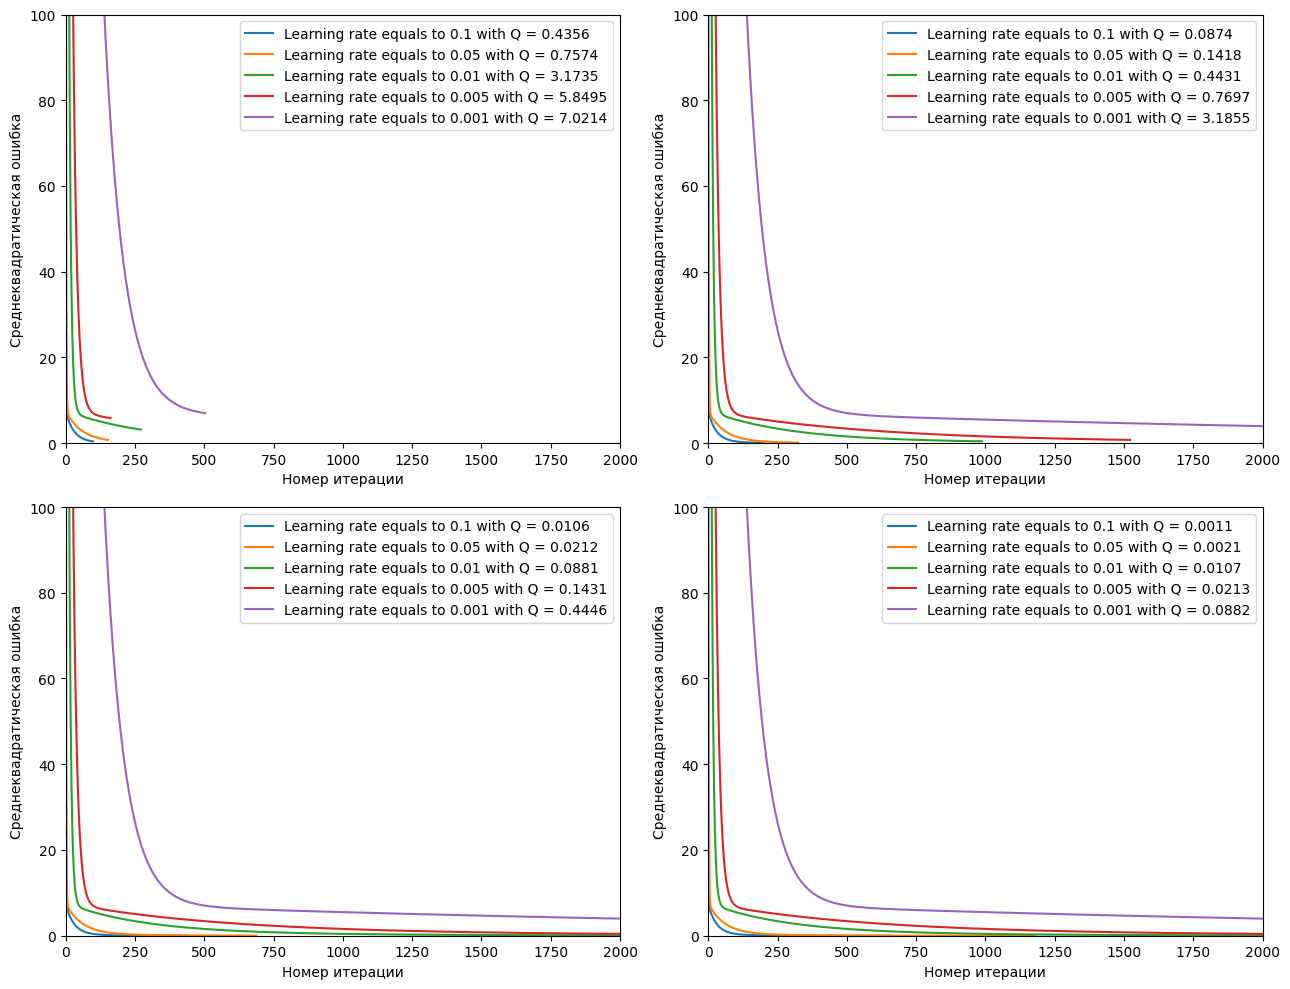

In [9]:
fig = plt.figure()

fig.set_size_inches(13, 10)

"""Задать списки для итераций"""
### Your code is here 
thresholds = [1e-2, 1e-3, 1e-4, 1e-5]
rates = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]

for i in range(len(thresholds)):
    """Задать threshold, добавить график на полонто, создать список для хранения значений функционала"""
    ### Your code is here
    treshold = thresholds[i]
    ax = fig.add_subplot(2,2,i+1)
    Q_values = []
    
    for lr in rates:
        """Создать объект модели, добавить константу, запустить обучение модели"""
        ### Your code is here
        GD = GradientDescentMse(
            samples=X, 
            targets=Y, 
            learning_rate=lr, 
            threshold=treshold
        )
        GD.add_constant_feature()
        GD.learn()
        
        """Определить learning_path через атрибут iteration_loss_dict"""
        ### Your code is here
        learning_path = GD.iteration_loss_dict
        
        """Отобразить learning_path на графике"""
        ### Your code is here
        plt.plot(
            list(learning_path.keys()), list(learning_path.values())
        )
        
        plt.ylim(0, 100)
        plt.xlim(0, 2000)
        
        Q_values.append(str(round(list(learning_path.values())[-1], ndigits=4)))
    
    plt.ylabel('Среднеквадратическая ошибка')
    plt.xlabel('Номер итерации')
    plt.legend([f'Learning rate equals to {rates[i]}' + ' with Q = ' + Q_values[i] for i in range(len(rates))])

fig.tight_layout() 

plt.show()